In [1]:
import datetime
import os
import random
from argparse import ArgumentParser
from pathlib import Path
from tqdm.autonotebook import tqdm

from pycocotools.cocoeval import COCOeval
import lightning as L
import numpy as np
import torch
from odection import (
    SSD,
    CocoDataset,
    Loss,
    ResNet,
    evaluate,
    SSDTransformer,
    collate_fn,
)
from odection.utils import Encoder, coco_classes, generate_dboxes
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter

/tmp/ipykernel_81012/2122917023.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
L.fabric.utilities.seed.seed_everything(42)

Global seed set to 42


42

In [3]:
BS = 128
LR = 3e-4
EPOCHS = 64
NUM_WORKERS = 4
MULTISTEP = [43, 54]
NMS_THRESHOLD = 0.5

DATA_PATH = Path("data/")
LOG_PATH = Path("logs/tensorboard/ssd")
SAVE_PATH = Path("models")
CHECKPOINT_PATH = SAVE_PATH / "ssd-checkpoint.pth"

LOG_PATH.mkdir(parents=True, exist_ok=True)
SAVE_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
str_date = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOG_PATH}/{str_date}")

In [5]:
torch.set_float32_matmul_precision("high")
fabric = L.Fabric(
    accelerator="auto",
    devices="auto",
    strategy="dp",
    precision="16-mixed",
    # loggers=SummaryWriter(f"{log_path}/{str_date}")
)
fabric.launch()

Using 16-bit Automatic Mixed Precision (AMP)


In [6]:
dboxes = generate_dboxes(model="ssd")

train_params = {
    "batch_size": BS,
    "shuffle": True,
    "drop_last": False,
    "num_workers": NUM_WORKERS,
    "collate_fn": collate_fn,
}
valid_params = {
    "batch_size": BS,
    "shuffle": False,
    "drop_last": False,
    "num_workers": NUM_WORKERS,
    "collate_fn": collate_fn,
}
train_set = CocoDataset(
    DATA_PATH,
    2017,
    "train",
    SSDTransformer(dboxes, (300, 300), val=False),
)
valid_set = CocoDataset(
    DATA_PATH,
    2017,
    "val",
    SSDTransformer(dboxes, (300, 300), val=True),
)
train_loader = fabric.setup_dataloaders(
    DataLoader(
        train_set,
        **train_params,
    )
)
valid_loader = fabric.setup_dataloaders(
    DataLoader(
        valid_set,
        **valid_params,
    )
)

loading annotations into memory...
Done (t=6.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [7]:
nms_threshold = NMS_THRESHOLD

model = SSD(backbone=ResNet(), num_classes=len(coco_classes))
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
)
model, optimizer = fabric.setup(model, optimizer)
scheduler = MultiStepLR(optimizer=optimizer, milestones=MULTISTEP, gamma=0.1)
criterion = Loss(dboxes, device=fabric.device)
encoder = Encoder(dboxes, device=fabric.device)

if CHECKPOINT_PATH.is_file():
    checkpoint = torch.load(CHECKPOINT_PATH)
    first_epoch = checkpoint["epoch"] + 1
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scheduler.load_state_dict(checkpoint["scheduler"])
else:
    first_epoch = 0

for i_epoch, epoch in enumerate(range(first_epoch, EPOCHS)):

    # ----- train stage -----
    model.train()
    num_iter_per_epoch = len(train_loader)
    progress_bar = tqdm(train_loader)
    for i, (image_in, _, _, gloc, glabel) in enumerate(progress_bar):
        ploc, plabel = model(image_in)
        ploc, plabel = ploc.float(), plabel.float()
        gloc = gloc.transpose(1, 2).contiguous()
        loss = criterion(ploc, plabel, gloc, glabel)
        progress_bar.set_description(f"Epoch: {epoch + 1}. Loss: {loss.item():.5f}")
        writer.add_scalar("Train/Loss", loss.item(), epoch * num_iter_per_epoch + i)
        fabric.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

    # ----- validation stage -----
    model.eval()
    detections = []
    category_ids = valid_loader.dataset.coco.getCatIds()
    for nbatch, (image_in, img_id, img_size, _, _) in enumerate(valid_loader):
        print(f"Parsing batch: {nbatch}/{len(valid_loader)}", end="\r")
        image_in = image_in.to(fabric.device)
        with torch.no_grad():
            # Get predictions
            ploc, plabel = model(image_in)
            ploc, plabel = ploc.float(), plabel.float()

            for idx in range(ploc.shape[0]):
                ploc_i = ploc[idx, :, :].unsqueeze(0)
                plabel_i = plabel[idx, :, :].unsqueeze(0)
                result = encoder.decode_batch(ploc_i, plabel_i, nms_threshold, 200)[0]
                try:
                    result = encoder.decode_batch(ploc_i, plabel_i, nms_threshold, 200)[
                        0
                    ]
                except Exception as exc:
                    # raise ValueError(f"No object detected in idx: {idx}")
                    print(f"No object detected in idx: {idx}")
                    continue

                height, width = img_size[idx]
                loc, label, prob = (r.cpu().numpy() for r in result)
                for loc_, label_, prob_ in zip(loc, label, prob):
                    detections.append(
                        [
                            img_id[idx],
                            loc_[0] * width,
                            loc_[1] * height,
                            (loc_[2] - loc_[0]) * width,
                            (loc_[3] - loc_[1]) * height,
                            prob_,
                            category_ids[label_ - 1],
                        ]
                    )

    detections = np.array(detections, dtype=np.float32)

    coco_eval = COCOeval(
        valid_loader.dataset.coco,
        valid_loader.dataset.coco.loadRes(detections),
        iouType="bbox",
    )
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    writer.add_scalar("Test/mAP", coco_eval.stats[0], epoch)

    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
    }
    torch.save(checkpoint, CHECKPOINT_PATH)

/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(664962, 7)
0/664962
DONE (t=2.47s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.85s).
Accumulating evaluation results...
DONE (t=3.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.118
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(637585, 7)
0/637585
DONE (t=3.81s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.37s).
Accumulating evaluation results...
DONE (t=3.61s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(595937, 7)
0/595937
DONE (t=2.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.88s).
Accumulating evaluation results...
DONE (t=3.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.143
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(607265, 7)
0/607265
DONE (t=2.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.96s).
Accumulating evaluation results...
DONE (t=3.42s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.081
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(608366, 7)
0/608366
DONE (t=2.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.88s).
Accumulating evaluation results...
DONE (t=3.31s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.153
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(522837, 7)
0/522837
DONE (t=2.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.69s).
Accumulating evaluation results...
DONE (t=2.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.153
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(549155, 7)
0/549155
DONE (t=0.57s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.52s).
Accumulating evaluation results...
DONE (t=3.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(561818, 7)
0/561818
DONE (t=2.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.74s).
Accumulating evaluation results...
DONE (t=3.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(523491, 7)
0/523491
DONE (t=2.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.96s).
Accumulating evaluation results...
DONE (t=2.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(563727, 7)
0/563727
DONE (t=2.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.77s).
Accumulating evaluation results...
DONE (t=3.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(564944, 7)
0/564944
DONE (t=2.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.74s).
Accumulating evaluation results...
DONE (t=3.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(522693, 7)
0/522693
DONE (t=2.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.05s).
Accumulating evaluation results...
DONE (t=2.91s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.164
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(542642, 7)
0/542642
DONE (t=2.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=20.69s).
Accumulating evaluation results...
DONE (t=2.99s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(528982, 7)
0/528982
DONE (t=2.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.45s).
Accumulating evaluation results...
DONE (t=2.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(560120, 7)
0/560120
DONE (t=2.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.85s).
Accumulating evaluation results...
DONE (t=3.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(507437, 7)
0/507437
DONE (t=2.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.90s).
Accumulating evaluation results...
DONE (t=2.89s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(552177, 7)
0/552177
DONE (t=2.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.73s).
Accumulating evaluation results...
DONE (t=3.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.171
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(459617, 7)
0/459617
DONE (t=2.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.92s).
Accumulating evaluation results...
DONE (t=2.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(489534, 7)
0/489534
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.63s).
Accumulating evaluation results...
DONE (t=2.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(482554, 7)
0/482554
DONE (t=2.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.50s).
Accumulating evaluation results...
DONE (t=2.76s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(470260, 7)
0/470260
DONE (t=2.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.32s).
Accumulating evaluation results...
DONE (t=2.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(466369, 7)
0/466369
DONE (t=1.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.26s).
Accumulating evaluation results...
DONE (t=2.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(473369, 7)
0/473369
DONE (t=2.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.41s).
Accumulating evaluation results...
DONE (t=2.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.170
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(532708, 7)
0/532708
DONE (t=2.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.44s).
Accumulating evaluation results...
DONE (t=2.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(514663, 7)
0/514663
DONE (t=2.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.12s).
Accumulating evaluation results...
DONE (t=2.92s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(487611, 7)
0/487611
DONE (t=2.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.65s).
Accumulating evaluation results...
DONE (t=2.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(495141, 7)
0/495141
DONE (t=1.97s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.64s).
Accumulating evaluation results...
DONE (t=2.86s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(494319, 7)
0/494319
DONE (t=2.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.57s).
Accumulating evaluation results...
DONE (t=2.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(452379, 7)
0/452379
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.89s).
Accumulating evaluation results...
DONE (t=2.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(523119, 7)
0/523119
DONE (t=2.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.21s).
Accumulating evaluation results...
DONE (t=2.92s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(455825, 7)
0/455825
DONE (t=2.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.09s).
Accumulating evaluation results...
DONE (t=2.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(489218, 7)
0/489218
DONE (t=2.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.73s).
Accumulating evaluation results...
DONE (t=2.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(471462, 7)
0/471462
DONE (t=2.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.41s).
Accumulating evaluation results...
DONE (t=2.72s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(461356, 7)
0/461356
DONE (t=2.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.94s).
Accumulating evaluation results...
DONE (t=2.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(452775, 7)
0/452775
DONE (t=2.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.82s).
Accumulating evaluation results...
DONE (t=2.62s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(483064, 7)
0/483064
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.90s).
Accumulating evaluation results...
DONE (t=2.82s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(459324, 7)
0/459324
DONE (t=2.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.36s).
Accumulating evaluation results...
DONE (t=2.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.172
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(475135, 7)
0/475135
DONE (t=1.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.79s).
Accumulating evaluation results...
DONE (t=2.76s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(502799, 7)
0/502799
DONE (t=2.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=19.37s).
Accumulating evaluation results...
DONE (t=2.92s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(452094, 7)
0/452094
DONE (t=1.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.15s).
Accumulating evaluation results...
DONE (t=2.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(413329, 7)
0/413329
DONE (t=1.94s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.11s).
Accumulating evaluation results...
DONE (t=2.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(429137, 7)
0/429137
DONE (t=1.87s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.29s).
Accumulating evaluation results...
DONE (t=2.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(421235, 7)
0/421235
DONE (t=0.44s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.19s).
Accumulating evaluation results...
DONE (t=2.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(410626, 7)
0/410626
DONE (t=0.43s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.26s).
Accumulating evaluation results...
DONE (t=2.56s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(418611, 7)
0/418611
DONE (t=1.81s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.49s).
Accumulating evaluation results...
DONE (t=2.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(404684, 7)
0/404684
DONE (t=1.87s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.97s).
Accumulating evaluation results...
DONE (t=2.38s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(411020, 7)
0/411020
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.25s).
Accumulating evaluation results...
DONE (t=2.42s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(401111, 7)
0/401111
DONE (t=1.79s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.27s).
Accumulating evaluation results...
DONE (t=2.41s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(412797, 7)
0/412797
DONE (t=1.93s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.11s).
Accumulating evaluation results...
DONE (t=2.44s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(404906, 7)
0/404906
DONE (t=0.43s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.24s).
Accumulating evaluation results...
DONE (t=2.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(405954, 7)
0/405954
DONE (t=1.87s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.97s).
Accumulating evaluation results...
DONE (t=2.39s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(403034, 7)
0/403034
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.28s).
Accumulating evaluation results...
DONE (t=2.41s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(402540, 7)
0/402540
DONE (t=1.90s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.17s).
Accumulating evaluation results...
DONE (t=2.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(403356, 7)
0/403356
DONE (t=1.88s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.94s).
Accumulating evaluation results...
DONE (t=2.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(399706, 7)
0/399706
DONE (t=0.44s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.89s).
Accumulating evaluation results...
DONE (t=2.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(395290, 7)
0/395290
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.87s).
Accumulating evaluation results...
DONE (t=2.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(402764, 7)
0/402764
DONE (t=1.77s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=17.26s).
Accumulating evaluation results...
DONE (t=2.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(403548, 7)
0/403548
DONE (t=1.92s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.97s).
Accumulating evaluation results...
DONE (t=2.39s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(389339, 7)
0/389339
DONE (t=0.41s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.07s).
Accumulating evaluation results...
DONE (t=2.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(403078, 7)
0/403078
DONE (t=1.85s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.98s).
Accumulating evaluation results...
DONE (t=2.39s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(394695, 7)
0/394695
DONE (t=0.41s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.78s).
Accumulating evaluation results...
DONE (t=2.38s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(400017, 7)
0/400017
DONE (t=1.82s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=15.88s).
Accumulating evaluation results...
DONE (t=2.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(391328, 7)
0/391328
DONE (t=1.80s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.77s).
Accumulating evaluation results...
DONE (t=2.34s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Recall

  0%|          | 0/925 [00:00<?, ?it/s]

Loading and preparing results...
Converting ndarray to lists...
(402253, 7)
0/402253
DONE (t=0.42s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=18.18s).
Accumulating evaluation results...
DONE (t=2.39s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Recall

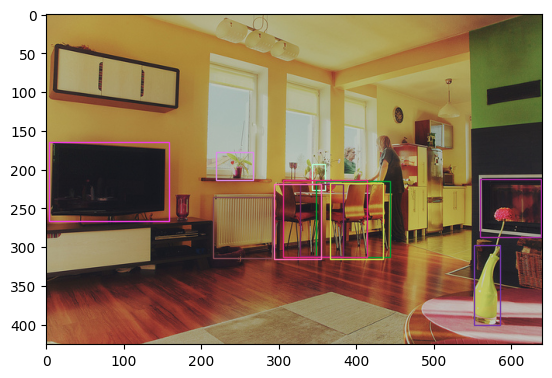

In [23]:
from pathlib import Path
import random
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from odection import generate_dboxes, Encoder, colors, coco_classes
from odection import SSD, SSDTransformer, ResNet


cls_threshold = 0.3
nms_threshold = 0.5
path_model_pretrained = Path("models/ssd-checkpoint.pth")
path_image_in = Path(
    "/workspaces/course-stepik_dl_advanced/project-objdet/data/val2017/000000000139.jpg"
)
path_image_out = Path("./") / path_image_in.name


model = SSD(backbone=ResNet())
checkpoint = torch.load(path_model_pretrained)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

dboxes = generate_dboxes()
transformer = SSDTransformer(dboxes, (300, 300), val=True)
image_in = Image.open(path_image_in).convert("RGB")
image_tr, _, _, _ = transformer(image_in, None, torch.zeros(1, 4), torch.zeros(1))
encoder = Encoder(dboxes)


with torch.no_grad():
    ploc, plabel = model(image_tr.unsqueeze(dim=0))
    result = encoder.decode_batch(ploc, plabel, nms_threshold, 20)[0]
    loc, label, prob = [r.cpu().numpy() for r in result]
    best = np.argwhere(prob > cls_threshold).squeeze(axis=1)
    loc = loc[best]
    label = label[best]
    prob = prob[best]

image_out = np.array(image_in)
# arr2im = Image.fromarray(im2arr)
fig, ax = plt.subplots()
ax.imshow(image_out)

if len(loc) > 0:
    height, width, _ = image_out.shape
    loc[:, 0::2] *= width
    loc[:, 1::2] *= height
    loc = loc.astype(np.int32)
    for box, lb, pr in zip(loc, label, prob):
        category = coco_classes[lb]
        color = colors[lb]
        xmin, ymin, xmax, ymax = box
        x0, y0, w, h = xmin, ymin, xmax - xmin, ymax - ymin
        rect = patches.Rectangle(
            (x0, y0),
            w,
            h,
            linewidth=1,
            edgecolor=[random.random() for _ in range(3)],
            facecolor="none",
        )
        ax.add_patch(rect)
        # ax.text(
        #     x0,
        #     y0,
        #     "left top",
        #     horizontalalignment="left",
        #     verticalalignment="top",
        #     transform=ax.transAxes,
        # )

        # cv2.rectangle(image_out, (xmin, ymin), (xmax, ymax), color, 2)
        # text_size = cv2.getTextSize(
        #     category + " : %.2f" % pr, cv2.FONT_HERSHEY_PLAIN, 1, 1
        # )[0]
        # cv2.rectangle(
        #     image_out,
        #     (xmin, ymin),
        #     (xmin + text_size[0] + 3, ymin + text_size[1] + 4),
        #     color,
        #     -1,
        # )
        # cv2.putText(
        #     image_out,
        #     category + " : %.2f" % pr,
        #     (xmin, ymin + text_size[1] + 4),
        #     cv2.FONT_HERSHEY_PLAIN,
        #     1,
        #     (255, 255, 255),
        #     1,
        # )
plt.show()
